# Setup
We need datasets, dataloaders, and code to train and evaluate models

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import h5py
import matplotlib.pyplot as plt

In [2]:
class RULDataset(Dataset):
    def __init__(self, X, y, dim="1d"):
        """
        Initialize the dataset by passing a DataFrame.
        Args:
            dataframe (pd.DataFrame): DataFrame with pixel data and labels.
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)  
        self.dim = dim

    def __len__(self):
        """
        Return the total number of samples in the dataset.
        """
        return len(self.y)

    def __getitem__(self, idx):
        """
        Retrieve a single sample from the dataset.
        Args:
            idx (int): Index of the sample to retrieve.
        Returns:
            (torch.Tensor, torch.Tensor): Tuple of features and label.
        """
        X_sample = self.X[idx]
        y_sample = self.y[idx]

        if self.dim == "2d":
            X_sample = X_sample.unsqueeze(0)
            
        return X_sample, y_sample

In [3]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=10):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_loss = float('inf')

    def early_stop(self, loss):
        if loss < self.min_loss:
            self.min_loss = loss
            self.counter = 0
        elif loss > (self.min_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [9]:
def create_train_test_dataloaders(X, y, test_size=0.2, batch_size=64, shuffle=True, dim="1d"):
    """
    Split the DataFrame into train and test sets and create DataLoaders.
    Args:
        dataframe (pd.DataFrame): DataFrame containing the data.
        test_size (float): Proportion of the data to be used as test data.
        batch_size (int): Number of samples per batch.
        shuffle (bool): Whether to shuffle the data.
    Returns:
        tuple: (train_loader, test_loader)
    """
    shuffle_idxs = np.random.permutation(len(y))
    X_shuffled = X[shuffle_idxs]
    y_shuffled = y[shuffle_idxs]
    
    split_idx = int(len(y) * test_size)
    X_test = X_shuffled[:split_idx]
    X_train = X_shuffled[split_idx:]
    y_test = y_shuffled[:split_idx]
    y_train = y_shuffled[:split_idx]
    
    # Create train and test datasets
    train_dataset = RULDataset(X_train, y_train, dim=dim)
    test_dataset = RULDataset(X_test, y_test, dim=dim)
    
    # Create DataLoaders for train and test sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

In [5]:
def load_from_hdf5(filename="data.h5"):
    with h5py.File(filename, "r") as f:
        X = f["X"][:]
        y = f["y"][:]
    return X, y

In [6]:
X, y = load_from_hdf5(filename="../engine_test_windows.h5")

In [10]:
def evaluate_model(model, data_loader, criterion, device, print_loss=True):
    model.eval()
    overall_loss = 0.0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Dynamically adjust input shape based on model type
            if isinstance(model, CNNRUL):
                inputs = inputs.permute(0, 2, 1)

            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            overall_loss += loss.item()

    avg_loss = overall_loss / len(data_loader)

    if print_loss:
        print(f"Test MSE: {avg_loss:.4f}")

    return avg_loss


def train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=5, track_test_loss=True):
    model.to(device)
    history = {'train_loss': [], 'test_loss': []}  
    early_stopper = EarlyStopper(patience=3, min_delta=.01)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # Adjust shape based on model type
            if isinstance(model, CNNRUL):  # 1D CNN
                inputs = inputs.permute(0, 2, 1)
                
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        if track_test_loss:
            avg_test_loss = evaluate_model(model, test_loader, criterion, device, print_loss=False)
            history['test_loss'].append(avg_test_loss)
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

            if early_stopper.early_stop(avg_test_loss):             
                break
        else:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

            if early_stopper.early_stop(avg_train_loss):             
                break

    return history

def plot_loss(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['test_loss'], label='Test Loss')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs. Test Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# 1d CNN
First, let's try a one dimensional CNN to capture temporal relationships within each feature.

In [11]:
class CNNRUL(nn.Module):
    def __init__(self, num_features):
        super(CNNRUL, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * (50 // 2 // 2 // 2), 64)  # Adjust based on pooling
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [12]:
train_loader, test_loader = create_train_test_dataloaders(X, y)

In [13]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [16]:
num_feats = 44
model = CNNRUL(num_features=num_feats).to(device)
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.000008)
num_epochs = 30 

history = train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=num_epochs)

Epoch 1/30, Train Loss: 547.6244, Test Loss: 530.9672
Epoch 2/30, Train Loss: 529.4249, Test Loss: 530.9401
Epoch 3/30, Train Loss: 529.5956, Test Loss: 529.8763
Epoch 4/30, Train Loss: 529.3600, Test Loss: 527.6739
Epoch 5/30, Train Loss: 529.5183, Test Loss: 528.8410
Epoch 6/30, Train Loss: 529.4139, Test Loss: 527.5535
Epoch 7/30, Train Loss: 528.7441, Test Loss: 528.7982
Epoch 8/30, Train Loss: 528.9510, Test Loss: 528.6252
Epoch 9/30, Train Loss: 529.1768, Test Loss: 533.9035


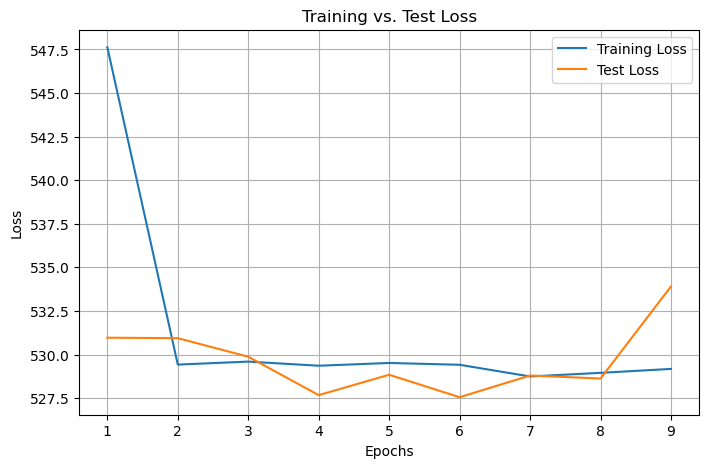

In [17]:
plot_loss(history)

# 2d CNN
Now, let's try out a two dimensional CNN to capture interactions among features.

In [15]:
class CNNRUL2D(nn.Module):
    def __init__(self, num_features):
        super(CNNRUL2D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1)

        self.pool = nn.MaxPool2d(kernel_size=(2, 2)) 

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * (50 // 2 // 2 // 2) * (num_features // 2 // 2 // 2), 64)
        self.fc2 = nn.Linear(64, 1) 

    def forward(self, x):
        # Input shape: [batch, 1, 50, 44]
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)

        # Flatten and pass through FC layers
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [42]:
train_loader, test_loader = create_train_test_dataloaders(X, y, dim="2d")

Epoch 1/10, Train Loss: 417.8115, Test Loss: 88.4992
Epoch 2/10, Train Loss: 87.0212, Test Loss: 86.1336
Epoch 3/10, Train Loss: 85.3384, Test Loss: 85.0036
Epoch 4/10, Train Loss: 84.2614, Test Loss: 84.1503
Epoch 5/10, Train Loss: 83.5022, Test Loss: 83.1992
Epoch 6/10, Train Loss: 82.9773, Test Loss: 82.8193
Epoch 7/10, Train Loss: 82.6988, Test Loss: 82.4988
Epoch 8/10, Train Loss: 82.5028, Test Loss: 82.4967
Epoch 9/10, Train Loss: 82.3418, Test Loss: 82.3393
Epoch 10/10, Train Loss: 82.2608, Test Loss: 82.5654


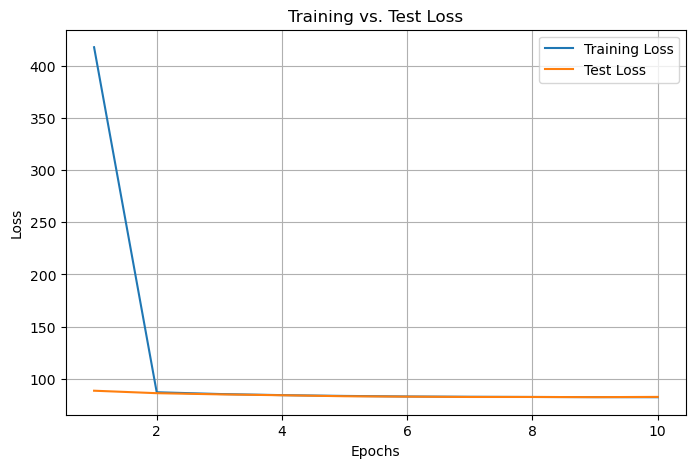

In [49]:
num_feats = 44
model = CNNRUL2D(num_features=num_feats).to(device)
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.00001)
num_epochs = 10 

history = train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=num_epochs)
plot_loss(history)

# Hybrid CNN
Now, let's try a hybrid CNN that uses both 1d and 2d convolutions.

In [45]:
class HybridCNN(nn.Module):
    def __init__(self, num_features, seq_length):
        super(HybridCNN, self).__init__()

        # 1d CNN Branch (Temporal Patterns)
        self.conv1d = nn.Conv1d(in_channels=num_features, out_channels=64, kernel_size=3, padding=1)
        self.pool1d = nn.MaxPool1d(kernel_size=2)  

        # 2d CNN Branch (Feature Interactions)
        self.conv2d = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1)
        self.pool2d = nn.MaxPool2d(kernel_size=(2, 2))  

        # Compute Fully Connected Layer Sizes
        fc1d_input_size = 64 * (seq_length // 2)  # After 1D CNN
        fc2d_input_size = 32 * ((seq_length // 2) * (num_features // 2))  # After 2D CNN

        self.fc1 = nn.Linear(fc1d_input_size + fc2d_input_size, 128)  
        self.fc2 = nn.Linear(128, 1)  

    def forward(self, x):
        # 1d CNN Branch
        x1d = x.permute(0, 2, 1)  # Convert [batch, seq_length, features] → [batch, features, seq_length]
        x1d = self.conv1d(x1d) 
        x1d = self.pool1d(torch.relu(x1d)) 
        x1d = torch.flatten(x1d, start_dim=1)  

        # 2d CNN Branch
        x2d = x.unsqueeze(1)  # Convert [batch, seq_length, features] → [batch, 1, seq_length, features]
        x2d = self.conv2d(x2d)  
        x2d = self.pool2d(torch.relu(x2d))  
        x2d = torch.flatten(x2d, start_dim=1) 

        # Combine both branches
        x_combined = torch.cat((x1d, x2d), dim=1)

        x_combined = torch.relu(self.fc1(x_combined))
        return self.fc2(x_combined)

In [46]:
train_loader, test_loader = create_train_test_dataloaders(X, y)

Epoch 1/10, Train Loss: 443.4683, Test Loss: 93.7016
Epoch 2/10, Train Loss: 88.4706, Test Loss: 85.3180
Epoch 3/10, Train Loss: 84.2204, Test Loss: 83.3956
Epoch 4/10, Train Loss: 83.1795, Test Loss: 82.7887
Epoch 5/10, Train Loss: 82.7142, Test Loss: 82.5133
Epoch 6/10, Train Loss: 82.4951, Test Loss: 82.3125
Epoch 7/10, Train Loss: 82.3591, Test Loss: 82.2087
Epoch 8/10, Train Loss: 82.3049, Test Loss: 82.1876
Epoch 9/10, Train Loss: 82.2554, Test Loss: 82.1437
Epoch 10/10, Train Loss: 82.2334, Test Loss: 82.1204


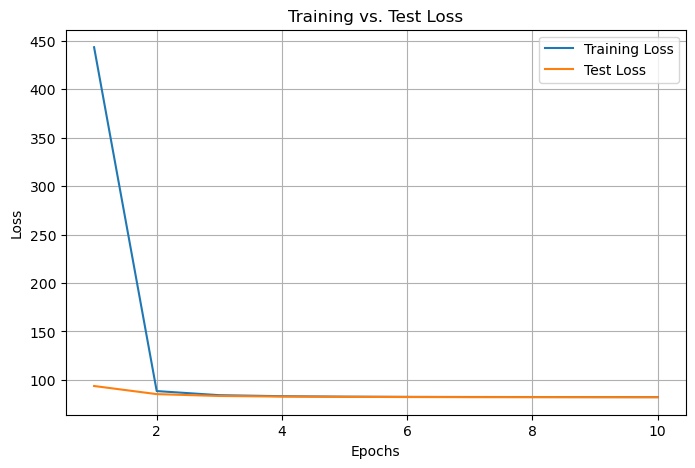

In [47]:
num_feats = 44
seq_length = 50  
model = HybridCNN(num_features=num_feats, seq_length=seq_length).to(device)
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
num_epochs = 10

history = train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=num_epochs)
plot_loss(history)

In [48]:
import matplotlib.pyplot as plt
import torch

def plot_rul_predictions(model, test_loader, device):
    """
    Plots predicted RUL vs. actual RUL for the test set.

    Parameters:
        model (torch.nn.Module): Trained model for RUL prediction.
        test_loader (DataLoader): DataLoader containing test data.
        device (str): 'cuda' or 'cpu' based on availability.
    """
    model.eval()  # Set model to evaluation mode
    actual_rul = []
    predicted_rul = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Ensure the input shape is correct for different models
            if isinstance(model, TCN):  # TCN requires (batch, features, seq_len)
                inputs = inputs.permute(0, 2, 1)  
            
            outputs = model(inputs).squeeze()  # Get predictions

            actual_rul.extend(targets.cpu().numpy())  
            predicted_rul.extend(outputs.cpu().numpy())

    # Convert to NumPy arrays for plotting
    actual_rul = np.array(actual_rul)
    predicted_rul = np.array(predicted_rul)

    # 🔹 Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(actual_rul, predicted_rul, alpha=0.5, label="Predicted vs Actual", color="blue")
    plt.plot([min(actual_rul), max(actual_rul)], [min(actual_rul), max(actual_rul)], 'r--', label="Perfect Prediction")  
    plt.xlabel("Actual RUL")
    plt.ylabel("Predicted RUL")
    plt.title("Predicted vs. Actual RUL")
    plt.legend()
    plt.grid(True)
    plt.show()


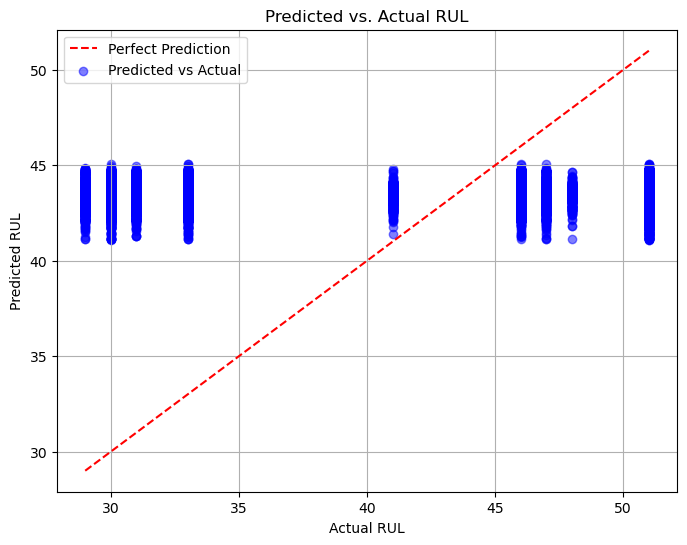

In [49]:
plot_rul_predictions(model, test_loader, device)

# More Complex Hybrid Model
The model's loss dropping drastically and then remaining stable might indicate underfitting. So, let's try adding additional convolutional layers.

In [29]:
import torch
import torch.nn as nn

class HybridCNN(nn.Module):
    def __init__(self, num_features, seq_length):
        super(HybridCNN, self).__init__()

        # 1d CNN Branch (Temporal Feature Extraction)
        self.conv1d_1 = nn.Conv1d(in_channels=num_features, out_channels=32, kernel_size=3, padding=1)
        self.conv1d_2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv1d_3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool1d = nn.MaxPool1d(kernel_size=2)  
        self.bn1d_1 = nn.BatchNorm1d(32)
        self.bn1d_2 = nn.BatchNorm1d(64)
        self.bn1d_3 = nn.BatchNorm1d(128)

        ## 2d CNN Branch (Feature Interactions)
        self.conv2d_1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1)
        self.conv2d_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1)
        self.conv2d_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1)
        self.pool2d = nn.MaxPool2d(kernel_size=(2, 2))  
        self.bn2d_1 = nn.BatchNorm2d(16)
        self.bn2d_2 = nn.BatchNorm2d(32)
        self.bn2d_3 = nn.BatchNorm2d(64)

        # Fully Connected Layers
        fc1d_input_size = 128 * (seq_length // 8)  # After three 1D CNN pooling layers
        fc2d_input_size = 64 * ((seq_length // 8) * (num_features // 8))  # After three 2D CNN pooling layers
        combined_fc_size = fc1d_input_size + fc2d_input_size

        self.fc1 = nn.Linear(combined_fc_size, 256)  
        self.fc2 = nn.Linear(256, 128)  
        self.fc3 = nn.Linear(128, 1)  

        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        # 1d CNN Branch
        x1d = x.permute(0, 2, 1)  # Convert [batch, seq_length, features] → [batch, features, seq_length]
        x1d = self.pool1d(torch.relu(self.bn1d_1(self.conv1d_1(x1d))))
        x1d = self.pool1d(torch.relu(self.bn1d_2(self.conv1d_2(x1d))))
        x1d = self.pool1d(torch.relu(self.bn1d_3(self.conv1d_3(x1d))))
        x1d = torch.flatten(x1d, start_dim=1)  

        # 2d CNN Branch
        x2d = x.unsqueeze(1)  # Convert [batch, seq_length, features] → [batch, 1, seq_length, features]
        x2d = self.pool2d(torch.relu(self.bn2d_1(self.conv2d_1(x2d))))
        x2d = self.pool2d(torch.relu(self.bn2d_2(self.conv2d_2(x2d))))
        x2d = self.pool2d(torch.relu(self.bn2d_3(self.conv2d_3(x2d))))
        x2d = torch.flatten(x2d, start_dim=1)  

        # Combine both branches
        x_combined = torch.cat((x1d, x2d), dim=1)

        # Fully Connected Layers
        x_combined = torch.relu(self.fc1(x_combined))
        x_combined = self.dropout(x_combined)
        x_combined = torch.relu(self.fc2(x_combined))
        x_combined = self.dropout(x_combined)

        return self.fc3(x_combined)  


Epoch 1/10, Train Loss: 242.6693, Test Loss: 848.5661
Epoch 2/10, Train Loss: 84.4321, Test Loss: 850.4301
Epoch 3/10, Train Loss: 90.6734, Test Loss: 799.4658
Epoch 4/10, Train Loss: 89.5035, Test Loss: 842.6759
Epoch 5/10, Train Loss: 96.9537, Test Loss: 821.4852
Epoch 6/10, Train Loss: 99.5839, Test Loss: 854.0989


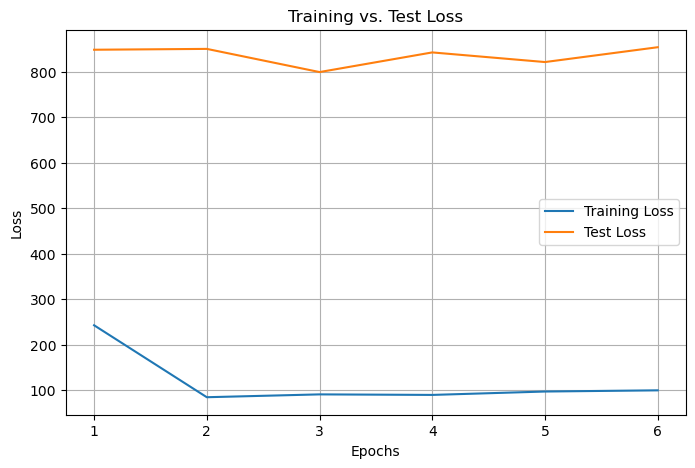

In [30]:
num_feats = 44
seq_length = 50  
model = HybridCNN(num_features=num_feats, seq_length=seq_length).to(device)
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
num_epochs = 10

history = train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=num_epochs)
plot_loss(history)

# Temporal CNN
Our more complex hybrid CNN was massively overfitting, so let's go in a different direction. Let's try a temporal CNN instead. 

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TemporalBlock(nn.Module):
    """
    A single block in a Temporal Convolutional Network (TCN).
    - Uses dilated causal convolutions, batch normalization, and residual connections.
    """
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout=0.2):
        super(TemporalBlock, self).__init__()

        padding = (kernel_size - 1) * dilation // 2  # 🔹 Ensures output shape matches input

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.dropout = nn.Dropout(dropout)

        # 🔹 Adjust residual connection if the number of channels changes
        self.downsample = nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        res = x if self.downsample is None else self.downsample(x)  # 🔹 Match channel size if needed

        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        return x + res  # 🔹 Ensures shape matches

class TCN(nn.Module):
    """
    Temporal Convolutional Network (TCN) for RUL Prediction.
    - Uses multiple TemporalBlocks with increasing dilation.
    - Outputs a single regression value per sequence.
    """
    def __init__(self, num_features, seq_length, num_channels=[64, 128, 256], kernel_size=3, dropout=0.2):
        super(TCN, self).__init__()

        layers = []
        num_levels = len(num_channels)

        for i in range(num_levels):
            dilation = 2 ** i  # 🔹 Exponentially increasing dilation rate
            in_channels = num_features if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]

            layers.append(TemporalBlock(in_channels, out_channels, kernel_size, dilation, dropout))

        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(num_channels[-1] * seq_length, 1)  # Fully connected output layer

    def forward(self, x):
        """
        x shape: [batch, seq_length, num_features]
        Expected shape: [batch, num_features, seq_length]
        """
        x = x.permute(0, 2, 1)  # 🔹 Convert [batch, seq_length, num_features] → [batch, num_features, seq_length]
        x = self.network(x)
        x = x.view(x.shape[0], -1)  # Flatten for FC layer
        return self.fc(x)


Epoch 1/20, Train Loss: 293.0956, Test Loss: 139.7629
Epoch 2/20, Train Loss: 83.4571, Test Loss: 115.6855
Epoch 3/20, Train Loss: 82.9422, Test Loss: 113.0972
Epoch 4/20, Train Loss: 82.5743, Test Loss: 106.8552
Epoch 5/20, Train Loss: 82.6225, Test Loss: 112.7304
Epoch 6/20, Train Loss: 82.5210, Test Loss: 110.3559
Epoch 7/20, Train Loss: 82.4830, Test Loss: 109.9316


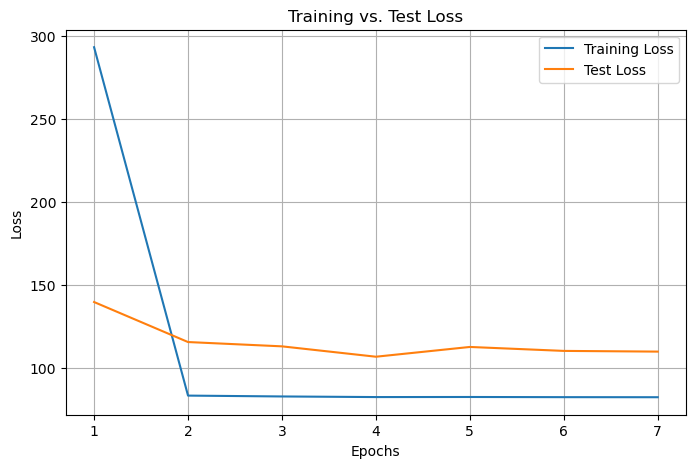

In [41]:
num_feats = 44
seq_length = 50
model = TCN(num_features=num_feats, seq_length=seq_length).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
num_epochs = 20

history = train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=num_epochs)
plot_loss(history)